In [2]:
import sys
from pathlib import Path


In [3]:
module_path = Path.cwd().parents[2]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [4]:
module_path


WindowsPath('c:/Users/Jurek/Desktop/Inżynierka/esw/evaluating-student-writing')

In [5]:
import json
import pickle
import random
from time import perf_counter

import regex as re

In [6]:
import spacy
import torch
from spacy.scorer import Scorer
from spacy.tokens import Doc, DocBin, Span
from spacy.training import Example


c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
METRICS_PATH = Path.cwd() / "metrics"
METRICS_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
torch.cuda.empty_cache()
# spacy.require_gpu()


In [9]:
from src.loader import TextLoader
from src.model import DatasetType, Text


In [10]:
loader = TextLoader(dataset_type=DatasetType.V1_WITH_PREDICTIONSTRING)
nlp = spacy.load("models/spacy_resume/model-best/")


c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
def create_manual_doc(text: Text):
    word_idx = []
    for disc in text.discourses:
        word_idx.extend((disc.predictionstring[0], disc.predictionstring[-1]))

    ents = []

    DS_token = "B-DS"
    DE_token = "B-DE"
    use_DS = True
    for ind, word in enumerate(text.words):
        if use_DS:
            curr_token = DS_token
        else:
            curr_token = DE_token

        if ind in word_idx:
            ents.append(curr_token)
            use_DS = not use_DS
        else:
            ents.append("O")

    return Doc(nlp.vocab, text.words, ents=ents)


def display_doc(doc: Doc):
    spacy.displacy.render(doc, style="ent", jupyter=True)


In [12]:
doc_bin = DocBin().from_disk("data/NER_test.spacy")
len(doc_bin)


780

In [13]:
examples = []
for ind, doc in enumerate(doc_bin.get_docs(nlp.vocab)):
    examples.append(Example.from_dict(doc, {"entities": doc.ents}))


In [14]:
path_pred = Path("data/predicted_examples.pkl")

if not path_pred.exists():
    predicted_examples: list[Example] = []
    for ind, example in enumerate(examples):
        print(f"\r{ind + 1:3d}/{len(examples)}", end="")
        doc = nlp(example.text)
        predicted_examples.append(Example(doc, example.reference))

    pickle.dump(predicted_examples, open(path_pred, "wb"))

else:
    with open(path_pred, "rb") as f:
        predicted_examples: list[Example] = pickle.load(f)


In [15]:
def get_fixed_doc(example: Example, idx: list[int]):
    doc = example.predicted
    ents = doc.ents

    tokens_fixed = []
    tokens_spaces = []
    ents_fixed = []
    curr_ind = idx.pop(0)
    for token in doc:
        if curr_ind is not None and token.i == curr_ind + 1:
            # tokens_fixex[-1] = tokens_fixex[-1] + token.text
            tokens_fixed.append(token.text)
            tokens_spaces.append(token.whitespace_)
            ents_fixed.append(f"I-{token.ent_type_}")
            if idx:
                curr_ind = idx.pop(0)
            else:
                curr_ind = None
        else:
            tokens_fixed.append(token.text)
            tokens_spaces.append(token.whitespace_)
            if token.ent_iob_ == "O":
                ents_fixed.append(token.ent_iob_)
            else:
                ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")

    return Doc(nlp.vocab, tokens_fixed, spaces=tokens_spaces, ents=ents_fixed)


In [16]:
def merge_invalid_examples(predicted_examples: list[Example], verbose: bool = False) -> list[Example]:
    merged_examples = []
    counter = 0
    for ind, example in enumerate(predicted_examples):
        ents = example.predicted.ents

        idx = []
        for i, ent in enumerate(ents[:-1]):
            next_ent = ents[i + 1]
            if ent.end == next_ent.start and ent.label_ == next_ent.label_ and "'" in next_ent.text:
                idx.append(ent.start)

        if not idx:
            merged_examples.append(example)
            continue

        counter += 1

        if verbose:
            print(f"ind: {ind}")
            for ent in ents:
                print(f"{ent.start:>3} {ent.end:>3} {ent.label_} {ent.text:12}", end=" ")
                if ent.start in idx:
                    print("<<<<<")
                else:
                    print()
            print("\n----\n")

        fixed_doc = get_fixed_doc(example, idx)

        if verbose:
            for ent in fixed_doc.ents:
                print(f"{ent.start:>3} {ent.end:>3} {ent.label_} {ent.text:12}")
            print("\n----\n")

        merged_examples.append(Example(fixed_doc, example.reference))

    print(f"Fixed {counter} examples.")

    return merged_examples


In [17]:
merged_examples = merge_invalid_examples(predicted_examples, verbose=True)
print(f"All examples: {len(examples)}")


ind: 9
  0   1 DS I            
  8   9 DE cars         
 17  18 DE computers    
 19  20 DS I            <<<<<
 20  21 DS 'm           
 32  33 DE machine      
 34  35 DS If           
 52  53 DE computer     
 66  67 DE job          
 83  84 DE wrong        
 85  86 DS Someone      
104 105 DE nowfunction  
106 107 DS Say          
208 209 DE of           
209 210 DS Now          
237 238 DE others       
239 240 DS We           
275 276 DE life         
277 278 DS So           
293 294 DE badly        

----

  0   1 DS I           
  8   9 DE cars        
 17  18 DE computers   
 19  21 DS I'm         
 32  33 DE machine     
 34  35 DS If          
 52  53 DE computer    
 66  67 DE job         
 83  84 DE wrong       
 85  86 DS Someone     
104 105 DE nowfunction 
106 107 DS Say         
208 209 DE of          
209 210 DS Now         
237 238 DE others      
239 240 DS We          
275 276 DE life        
277 278 DS So          
293 294 DE badly       

----

ind: 11
  0   1 DS

In [18]:
# Predicted ind: 14 has some issues with consequent DS/DE entities
display_doc(merged_examples[9].predicted)


In [19]:
def inference_missing_tags(
    examples: list[Example], use_first: bool = False, use_sentence_boundaries: bool = True
) -> list[Example]:
    """
    It may happened that consequitive tags are of the same type, e.g. ... DS DE DE ...
    which is not ideal as we cannot extract discourses from it. This function tries to add
    missing tags to such cases based on couple of rules:

    1. For the sequence of tags there musn't be any consequitive tags of the same type.
    2. For missing tags (e.g. DS DE DE we will try to find missing DS tag so that it becomes
       DS DE DS DE).
    3. Missing tag is added only as a start / end of sentence. In case of situation where
       there are couple of sentences between two consequitive tags, we can use either use first
       approach (add missing tag to the first found sentence) or use last approach (add
       missing tag to the last found sentence).
    4. If use_sentence_boundaries is set to True, then we will try to add missing tags only
       at the start / end of sentence. If this is not possible, the middle consequitive tag will be
       removed. If use_sentence_boundaries is set to False, then the missing tag will be added to the
       first / last untagged token before the next consequitive tag if there is no sentence boundary.
    """
    fixed_examples = []
    for ind, example in enumerate(examples):
        print(f"\r{ind:3d}/{len(examples) - 1}", end="")

        doc = example.predicted

        last_ent = None
        last_ent_ind = None

        last_start_sent_ind = 0
        last_end_sent_ind = 0

        saved_first_token_ind = None

        tokens_fixed = []
        tokens_spaces = []
        ents_fixed = []

        for ind, token in enumerate(doc):
            tokens_fixed.append(token.text)
            tokens_spaces.append(token.whitespace_)

            if (
                last_start_sent_ind is not None
                and last_start_sent_ind < ind
                and ents_fixed
                and last_ent is not None
            ):
                # Check if last idx are set on proper tokens, if not remove them
                if last_ent == "DE":
                    if ents_fixed[last_start_sent_ind] in ("B-DS", "I-DS", "B-DE", "I-DE"):
                        last_start_sent_ind, last_end_sent_ind = None, None
                else:
                    if ents_fixed[last_end_sent_ind] in ("B-DS", "I-DS", "B-DE", "I-DE"):
                        last_start_sent_ind, last_end_sent_ind = None, None

            if use_first and last_start_sent_ind is None and token.text == ".":
                last_start_sent_ind = ind + 1
                last_end_sent_ind = ind - 1

            elif not use_first and token.text == ".":
                last_start_sent_ind = ind + 1
                last_end_sent_ind = ind - 1

            if not token.ent_type_:
                if saved_first_token_ind is None:
                    saved_first_token_ind = ind

                ents_fixed.append(token.ent_iob_)
                continue

            if (token.ent_type_ == "DS" and last_ent == "DE") or (
                token.ent_type_ == "DE" and last_ent == "DS"
            ):
                last_ent = token.ent_type_
                last_ent_ind = ind
                ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")

                # Okay so reset them
                last_start_sent_ind, last_end_sent_ind = None, None
                saved_first_token_ind = None
                continue

            if last_ent is None and token.ent_type_ == "DS":
                last_ent = token.ent_type_
                last_ent_ind = ind

                last_start_sent_ind, last_end_sent_ind = None, None
                saved_first_token_ind = None

                ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")
                continue

            assert not (token.ent_type_ == "DE" and ind == 0), "First token must not be DE"

            # print(f"Current token: {token.text} {token.ent_iob_}-{token.ent_type_}")
            # print(f"Added ents: {ents_fixed}")
            if last_start_sent_ind is not None:
                if token.ent_type_ == "DE":
                    # print(
                    #     f"Last start sent ind: {last_start_sent_ind} - {tokens_fixed[last_start_sent_ind]} {ents_fixed[last_start_sent_ind]}"
                    # )
                    assert ents_fixed[last_start_sent_ind] not in (
                        "B-DS",
                        "I-DS",
                        "B-DE",
                        "I-DE",
                    ), "The tag for the start of sentence is already set!"
                    ents_fixed[last_start_sent_ind] = "B-DS"
                elif token.ent_type_ == "DS":
                    # print(
                    #     f"Last end sent ind: {last_end_sent_ind} - {tokens_fixed[last_end_sent_ind]} {ents_fixed[last_end_sent_ind]}"
                    # )
                    assert ents_fixed[last_end_sent_ind] not in (
                        "B-DS",
                        "I-DS",
                        "B-DE",
                        "I-DE",
                    ), "The tag for the end of sentence is already set!"
                    ents_fixed[last_end_sent_ind] = "B-DE"
                else:
                    assert False, "Should not happen"
            else:
                if token.ent_iob_ == "I" and ents_fixed[ind - 1] == f"B-{token.ent_type_}":
                    # Fixed case like:
                    # I  B-DS
                    # 'm I-DS
                    last_ent = token.ent_type_
                    last_ent_ind = ind
                    ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")
                    continue
                elif ents_fixed[ind - 1] == f"B-{token.ent_type_}":
                    # Two consequitive DS / DE tags that were not fixed so we leave
                    # the first one and remove the second one (for DS) and
                    # remove the first one and leave the second one (for DE)
                    if token.ent_type_ == "DS":
                        ents_fixed.append("O")
                    else:
                        ents_fixed[ind - 1] = "O"
                        ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")
                    continue

                if use_sentence_boundaries:
                    # Remove middle consequitive tag
                    if ents_fixed[last_ent_ind].startswith("I-"):
                        # Entity is composed of more than one token
                        curr_ind = last_ent_ind
                        while last_ent in ents_fixed[curr_ind]:
                            ents_fixed[curr_ind] = "O"
                            curr_ind -= 1
                    else:
                        ents_fixed[last_ent_ind] = "O"
                else:
                    # Add missing tag to the first / last untagged token
                    if token.ent_type_ == "DE":
                        assert ents_fixed[saved_first_token_ind] not in (
                            "B-DS",
                            "I-DS",
                            "B-DE",
                            "I-DE",
                        ), "Start token already has a tag"
                        ents_fixed[saved_first_token_ind] = "B-DS"
                    elif token.ent_type_ == "DS":
                        assert ents_fixed[ind - 1] not in (
                            "B-DS",
                            "I-DS",
                            "B-DE",
                            "I-DE",
                        ), "End token already has a tag"
                        ents_fixed[ind - 1] = "B-DE"
                    else:
                        assert False, "Should not happen"

            last_start_sent_ind, last_end_sent_ind = None, None
            saved_first_token_ind = None

            last_ent = token.ent_type_
            last_ent_ind = ind
            ents_fixed.append(f"{token.ent_iob_}-{token.ent_type_}")

        # For cases when last token should be DE
        if last_ent == "DS" and last_end_sent_ind is not None:
            ents_fixed[last_end_sent_ind] = "B-DE"
        elif last_ent == "DS":
            assert ents_fixed[-1] not in (
                "B-DS",
                "I-DS",
                "B-DE",
                "I-DE",
            ), "Last token already has a tag"
            ents_fixed[-1] = "B-DE"

        # Check if each DS tag has a DE tag and vice versa
        ents_filtered = [ent for ent in ents_fixed if ent != "O" and not ent.startswith("I-")]
        assert len(ents_filtered) % 2 == 0, f"Example {ind} has uneven number of tags: {ents_filtered}!"


        doc_fixed = Doc(nlp.vocab, tokens_fixed, spaces=tokens_spaces, ents=ents_fixed)
        fixed_examples.append(Example(doc_fixed, example.reference))

    print()

    return fixed_examples


In [20]:
inferenced_last_loose = inference_missing_tags(
    merged_examples, use_first=False, use_sentence_boundaries=False
)
inferenced_last_sents = inference_missing_tags(
    merged_examples, use_first=False, use_sentence_boundaries=True
)
inferenced_first_loose = inference_missing_tags(
    merged_examples, use_first=True, use_sentence_boundaries=False
)
inferenced_first_sents = inference_missing_tags(
    merged_examples, use_first=True, use_sentence_boundaries=True
)


779/779
779/779
779/779
779/779


In [21]:
num = 15

display_doc(merged_examples[num].predicted)
print("\nLast loose\n")
display_doc(inferenced_last_loose[num].predicted)
print("\nLast sents\n")
display_doc(inferenced_last_sents[num].predicted)
print("\nFirst loose\n")
display_doc(inferenced_first_loose[num].predicted)
print("\nFirst sents\n")
display_doc(inferenced_first_sents[num].predicted)



Last loose




Last sents




First loose




First sents



In [22]:
start = perf_counter()
metrics = nlp.evaluate(predicted_examples, batch_size=256)
with open(METRICS_PATH / "predicted_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Predicted done in {perf_counter() - start:.2f}s")

# ----

start = perf_counter()
metrics = nlp.evaluate(merged_examples, batch_size=256)
with open(METRICS_PATH / "merged_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Merged done in {perf_counter() - start:.2f}s")

# ----

start = perf_counter()
metrics = nlp.evaluate(inferenced_last_loose, batch_size=256)
with open(METRICS_PATH / "last_loose_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Last loose done in {perf_counter() - start:.2f}s")

# ----

start = perf_counter()
metrics = nlp.evaluate(inferenced_last_sents, batch_size=256)
with open(METRICS_PATH / "last_sents_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Last sents done in {perf_counter() - start:.2f}s")

# ----

start = perf_counter()
metrics = nlp.evaluate(inferenced_first_loose, batch_size=256)
with open(METRICS_PATH / "first_loose_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"First loose done in {perf_counter() - start:.2f}s")

# ----

start = perf_counter()
metrics = nlp.evaluate(inferenced_first_sents, batch_size=256)
with open(METRICS_PATH / "first_sents_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"First sents done in {perf_counter() - start:.2f}s")

KeyboardInterrupt: 

In [23]:
# Print all metrics
for path in METRICS_PATH.glob("*.json"):
    with open(path) as f:
        metrics = json.load(f)
    
    print(path.stem)
    print(metrics, end="\n\n")

first_loose_metrics
{'token_acc': 1.0, 'token_p': 0.9773659229601885, 'token_r': 0.9885548875528836, 'token_f': 0.9829285644702777, 'ents_p': 0.664534238527319, 'ents_r': 0.7265201256066229, 'ents_f': 0.6941461252599639, 'ents_per_type': {'DS': {'p': 0.6378209305356445, 'r': 0.6978468558391558, 'f': 0.6664850878387579}, 'DE': {'p': 0.6913418781061993, 'r': 0.7552507501071581, 'f': 0.7218846022533287}}, 'speed': 1574.9439401179864}

first_sents_metrics
{'token_acc': 1.0, 'token_p': 0.9773659229601885, 'token_r': 0.9885548875528836, 'token_f': 0.9829285644702777, 'ents_p': 0.6710648455112054, 'ents_r': 0.7223094490436769, 'ents_f': 0.6957448271121193, 'ents_per_type': {'DS': {'p': 0.64591387814958, 'r': 0.6908598317410524, 'f': 0.6676312525837121}, 'DE': {'p': 0.6959504023215934, 'r': 0.7538219745677954, 'f': 0.7237311385459534}}, 'speed': 1570.9460602195804}

last_loose_metrics
{'token_acc': 1.0, 'token_p': 0.9773659229601885, 'token_r': 0.9885548875528836, 'token_f': 0.9829285644702777

In [24]:
def extract_discourses(doc: Doc, keep_first_ds: bool = False, keep_first_de: bool = False):
    discourses = []
    tokens = [token.text for token in doc]

    last_ent = None
    ents = []
    deleted_offset = 0
    for ind, ent in enumerate(doc.ents):
        if ent.label_ == "DS" and last_ent == "DS":
            if not keep_first_ds:
                ents[ind - deleted_offset - 1] = ent

            deleted_offset += 1
            continue

        if ent.label_ == "DE" and last_ent == "DE":
            if not keep_first_de:
                ents[ind - deleted_offset - 1] = ent

            deleted_offset += 1
            continue

        ents.append(ent)
        last_ent = ent.label_

    last_tag = None
    for ind, ent in enumerate(ents):
        if ent.label_ == "DS":
            start_pos = ent.start
            last_tag = "DS"
            continue

        if ent.label_ == "DE":
            assert last_tag == "DS", "DE without DS"
            disc = " ".join(tokens[start_pos : ent.end])
            disc = re.sub(r" \.", ".", disc)
            discourses.append(disc)
            start_pos = None
            last_tag = "DE"
            continue

    return discourses


In [25]:
re.sub(r" \.", ".", inferenced_last_loose[num].text).strip()

"When you put cell phones and driving together you wont get a good outcome. Statistics show that every year 1. 6 million crashes happen because of cell phone use. I believe that sometimes you may really need your phone for emergencies but with the new technology there are safer ways to answer the phone while driving. I truly believe cell phone use shouldn't be allowed while operating a vehicle for the safety of ourselves and others. Over the past few years cell phone use has become one of the leading causes for car accidents. So why would people continue to put themselves in that situation daily Cell phones are an addiction its proven that swiping on some of the apps we have causes our brain to release dopamine. I know how it is getting that notification and automatically wanting to grab your phone and that's also a reason why so many teen car accidents happen. Teens are the majority of whats on social media and not every teen realizes the seriousness of driving. Even Though cell phone

In [26]:
with open("../flair/data/ids_test1.txt", "r")as f:
    ids = f.readlines() 

In [27]:
import numpy as np
import pandas as pd
import sys
import pickle
sys.path.append("../../")
sys.path.append("../")
import spacy
from src.loader import TextLoader
from src.purifier import Purifier
from tqdm import tqdm
from pathlib import Path
import torch

from transformers import BertTokenizer
from torch import nn
from transformers import BertModel

from transformers import RobertaTokenizer
from transformers import RobertaModel

In [28]:
class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.4):

        super(RobertaClassifier, self).__init__()

        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, 64)
        self.dropout3 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout1_output = self.dropout1(pooled_output)
        linear1_output = self.linear1(dropout1_output)
        dropout2_output = self.dropout2(linear1_output)
        linear2_output = self.linear2(dropout2_output)
        dropout3_output = self.dropout3(linear2_output)
        linear3_output = self.linear3(dropout3_output)
        final_layer = self.relu(linear3_output)

        return final_layer

In [29]:
the_model = torch.load("../../classification/roberta_classifier_short_model_5_epochs_1_undersampling")

In [30]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [31]:
def predict(model, test_data):

    labels = {'Lead':0,
          'Position':1,
          'Evidence':2,
          'Claim':3,
          'Concluding Statement':4,
          'Counterclaim':5, 
          'Rebuttal':6
    }

    predicted_labels = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():

        for test_input in test_data:

            token = tokenizer(test_input, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

            mask = token['attention_mask'].to(device)
            input_id = token['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            result = int(output.argmax(dim=1))

            for key, value in labels.items():
                if result == value:
                    #print(key,":",test_input)
                    #print()
                    predicted_labels.append(key)

    return predicted_labels
                    

In [32]:
from copy import deepcopy

In [42]:
def create_new_doc(doc: Doc, keep_first_de=False, keep_first_ds=False):
    new_doc = deepcopy(doc)
    ents = doc.ents
    prev = None
    new_ents = []
    for ent in ents:
        if ent.label_ == "DS":
            if keep_first_ds:
                if prev != "DS":
                    new_ents.append(Span(new_doc, ent.start, ent.end, "DS"))
                    prev = ent.label_
                else:
                    continue
            else:
                if prev == "DS":
                    new_ents[len(new_ents)-1] = Span(new_doc, ent.start, ent.end, "DS")
                    prev = ent.label_
                else:
                    new_ents.append(Span(new_doc, ent.start, ent.end, "DS"))
                    prev = ent.label_
        else:
            if keep_first_de:
                if prev != "DE":
                    new_ents.append(Span(new_doc, ent.start, ent.end, "DE"))
                    prev = ent.label_
                else:
                    continue
            else:
                if prev == "DE":
                    new_ents[len(new_ents)-1] = Span(new_doc, ent.start, ent.end, "DE")
                    prev = ent.label_
                else:
                    new_ents.append(Span(new_doc, ent.start, ent.end, "DE"))
                    prev = ent.label_
    if new_ents[0].label_ == "DE":
        new_ents = new_ents[1:]
    if new_ents[-1].label_ == "DS":
        new_ents = new_ents[:-1]
    
    new_doc.set_ents(new_ents)

    return new_doc


create_new_doc(merged_examples[163].predicted, False, True)

Dear principal I believe that allowing student to bring phones to school and using them during lunch period and free time but as long as the phones are off during class time is a bad idea because what if the student don't listen to the policy and they have there phones out during classes and there texting during there class and when the teacher ask what is the answer to 2836 847 they don't the answer how they be able to learn . Here's an example I think I can bring my phone to school and text call go on the internet go on facebook do what ever i want do and if it goes to far . That student will start to fail school and not doing the homework . That student will start going to classes . Then start skip school her so cool and popular . I also believe don't allow student to have phone at school at all is another bad idea because what if student needs to call home call someone else what if a group of student are walking to school and someone got shot how would they call the police if there

In [49]:
def create_discourse_doc(doc: Doc, text_id, is_pred = True, keep_first_de=False, keep_first_ds=False, fix_doc = False):
    words = [token.text for token in doc]

    if fix_doc:
        doc = create_new_doc(doc, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds)

    if is_pred:
        discourses = extract_discourses(doc, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds)
        labels = predict(the_model, discourses)
        assert len(labels) == len(discourses)
    else:
        origin = loader.load_text_with_id(text_id)
        labels = [disc.type.value for disc in origin.discourses]


    ents = []
    in_disc = False
    c = -1
    list_of_labels = []
    last_type = None
    
    for token in doc:
        if last_type == "DE" and token.ent_type_ != "DE":
            in_disc = False
            
        if token.ent_type_ == "DS":
            if token.ent_iob_ == "I":
                ents.append(f"I-{labels[c]}")
            else:
                c+=1
                ents.append(f"B-{labels[c]}")
                in_disc = True
            list_of_labels.append(labels[c])
        elif token.ent_type_ == "DE":
            list_of_labels.append(labels[c])
            if token.ent_iob_ == "I":
                ents.append(f"I-{labels[c]}")
            else:
                ents.append(f"B-{labels[c]}")
        elif in_disc:
            list_of_labels.append(labels[c])
            ents.append(f"I-{labels[c]}")
        else:
            list_of_labels.append("Not Discourse")
            ents.append("O")
        last_type = token.ent_type_

    return Doc(nlp.vocab, words, ents=ents), list_of_labels

In [50]:
def extract_discourses(doc: Doc, keep_first_ds: bool = False, keep_first_de: bool = False):
    discourses = []
    tokens = [token.text for token in doc]

    last_ent = None
    ents = []
    deleted_offset = 0
    for ind, ent in enumerate(doc.ents):
        if ent.label_ == "DS" and last_ent == "DS":
            if not keep_first_ds:
                ents[ind - deleted_offset - 1] = ent

            deleted_offset += 1
            continue

        if ent.label_ == "DE" and last_ent == "DE":
            if not keep_first_de:
                ents[ind - deleted_offset - 1] = ent

            deleted_offset += 1
            continue

        ents.append(ent)
        last_ent = ent.label_

    last_tag = None
    for ind, ent in enumerate(ents):
        if ent.label_ == "DS":
            start_pos = ent.start
            last_tag = "DS"
            continue

        if ent.label_ == "DE":
            assert last_tag == "DS", "DE without DS"
            disc = " ".join(tokens[start_pos : ent.end])
            disc = re.sub(r" \.", ".", disc)
            discourses.append(disc)
            start_pos = None
            last_tag = "DE"
            continue

    return discourses

In [51]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [58]:
def calc_score_for_test(dataset, ids, keep_first_de=False, keep_first_ds=False, fix_doc = False):
    y_pred = []
    y_true = []
    for i, data in enumerate(dataset):
        ppred,list_of_labels_ppred = create_discourse_doc(data.predicted, ids[i].strip(), True, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds, fix_doc= fix_doc)
        rref, list_of_labels_rref = create_discourse_doc(data.reference, ids[i].strip(), False, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds, fix_doc= fix_doc)

    
        shift = 0
        indexes = []
        for i,token in enumerate(rref):
            if str(token) == str(ppred[i+shift]):
                continue
            else:
                indexes.append(i)
                shift+=1
        new_list_of_labels_ppred = [token for i,token in enumerate(list_of_labels_ppred) if i not in indexes]
        
        y_pred += new_list_of_labels_ppred
        y_true += list_of_labels_rref

    print('weighted', f1_score(y_true, y_pred, average='weighted'))
    print('micro', f1_score(y_true, y_pred, average='micro'))
    print('macro', f1_score(y_true, y_pred, average='macro'))
    print('matthews_corrcoef', matthews_corrcoef(y_true, y_pred))

    fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                labels=['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement','Counterclaim', 'Rebuttal'], 
                                                cmap=plt.cm.Blues,
                                                )
    fig = fig.ax_.get_figure() 
    fig.set_figwidth(20)
    fig.set_figheight(12)

In [ ]:
def calc_score_for_test(dataset, ids, keep_first_de=False, keep_first_ds=False, fix_doc = False):
    y_pred = []
    y_true = []
    for i, data in enumerate(dataset):
        ppred,list_of_labels_ppred = create_discourse_doc(data.predicted, ids[i].strip(), True, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds, fix_doc= fix_doc)
        rref, list_of_labels_rref = create_discourse_doc(data.reference, ids[i].strip(), False, keep_first_de=keep_first_de, keep_first_ds=keep_first_ds, fix_doc= fix_doc)

    
        shift = 0
        indexes = []
        for i,token in enumerate(rref):
            if str(token) == str(ppred[i+shift]):
                continue
            else:
                indexes.append(i)
                shift+=1
        new_list_of_labels_ppred = [token for i,token in enumerate(list_of_labels_ppred) if i not in indexes]
        
        y_pred += new_list_of_labels_ppred
        y_true += list_of_labels_rref

    #TODO nowa metryka na y_pred i y_true


    print('weighted', f1_score(y_true, y_pred, average='weighted'))
    print('micro', f1_score(y_true, y_pred, average='micro'))
    print('macro', f1_score(y_true, y_pred, average='macro'))
    print('matthews_corrcoef', matthews_corrcoef(y_true, y_pred))

    fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                labels=['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement','Counterclaim', 'Rebuttal'], 
                                                cmap=plt.cm.Blues,
                                                )
    fig = fig.ax_.get_figure() 
    fig.set_figwidth(20)
    fig.set_figheight(12)

weighted 0.6711555503412271
micro 0.6740117271580197
macro 0.5359745620852967
matthews_corrcoef 0.5255739518994378


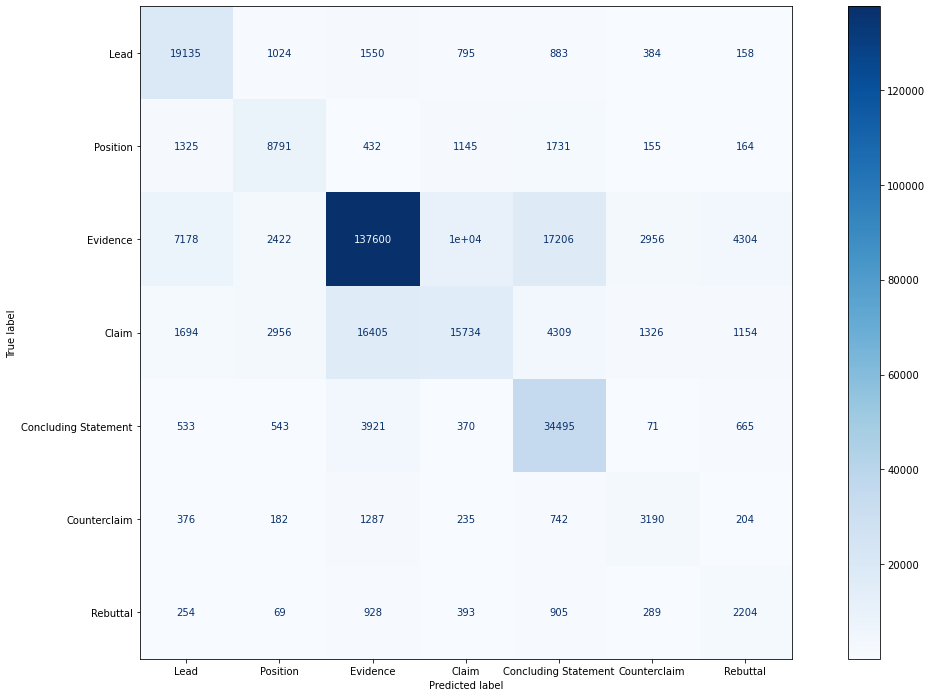

In [69]:
calc_score_for_test(predicted_examples, ids, False, True, True)

weighted 0.6464962390090374
micro 0.6321828842870927
macro 0.5177956618288596
matthews_corrcoef 0.49240583362036644


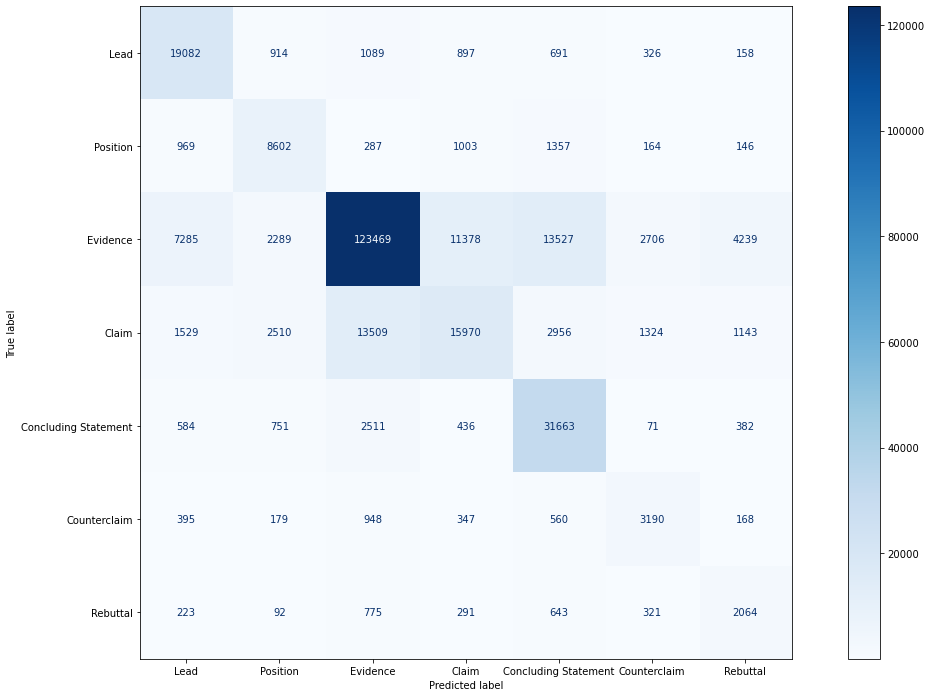

In [94]:
calc_score_for_test(predicted_examples, ids, True, True, True)

weighted 0.6612327383707222
micro 0.659535367030357
macro 0.5224370268006832
matthews_corrcoef 0.5116773577534484


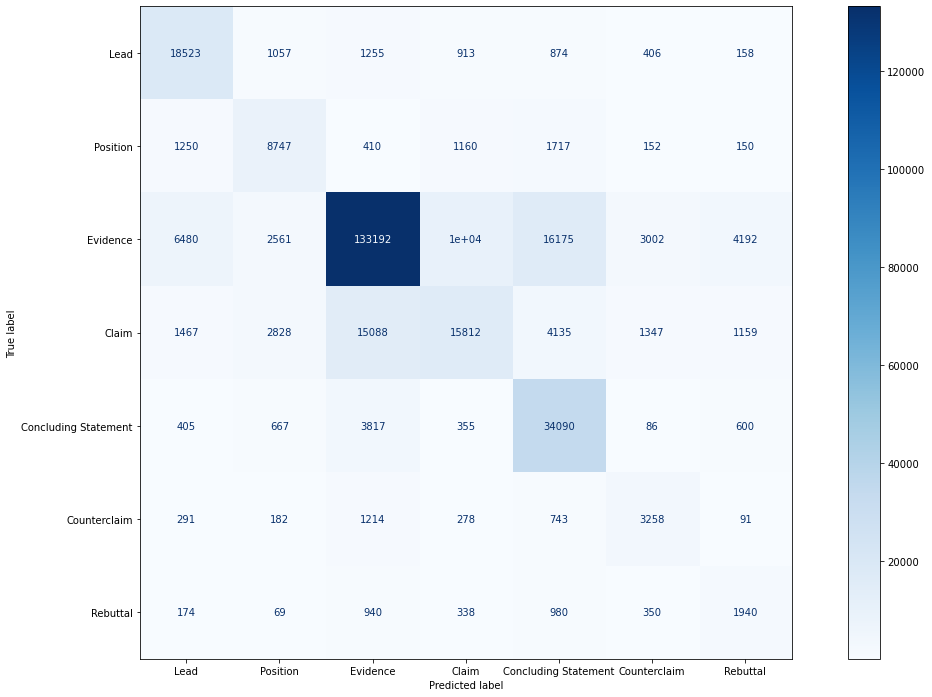

In [71]:
calc_score_for_test(predicted_examples, ids, False, False, True)

weighted 0.6339925072512662
micro 0.6127929933941958
macro 0.5078753082252498
matthews_corrcoef 0.47725559172812454


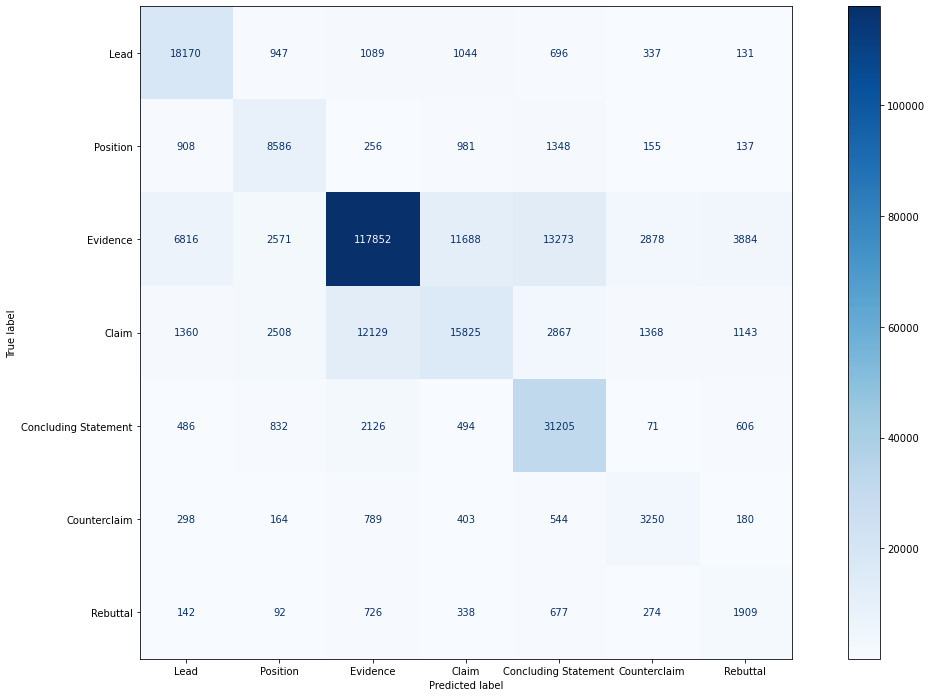

In [72]:
calc_score_for_test(predicted_examples, ids, True, False, True)

weighted 0.6688206002586784
micro 0.6714881615082016
macro 0.5330562840033667
matthews_corrcoef 0.5227818685372738


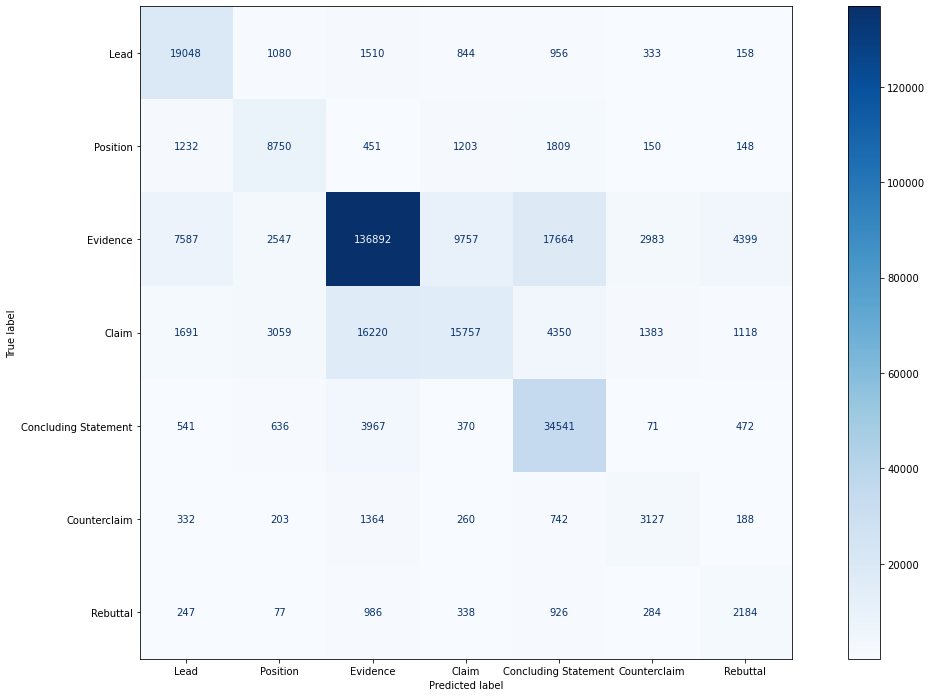

In [59]:
calc_score_for_test(merged_examples, ids, False, True, True)

weighted 0.6593610205878945
micro 0.6577213686632525
macro 0.5208509790740004
matthews_corrcoef 0.5096056639659617


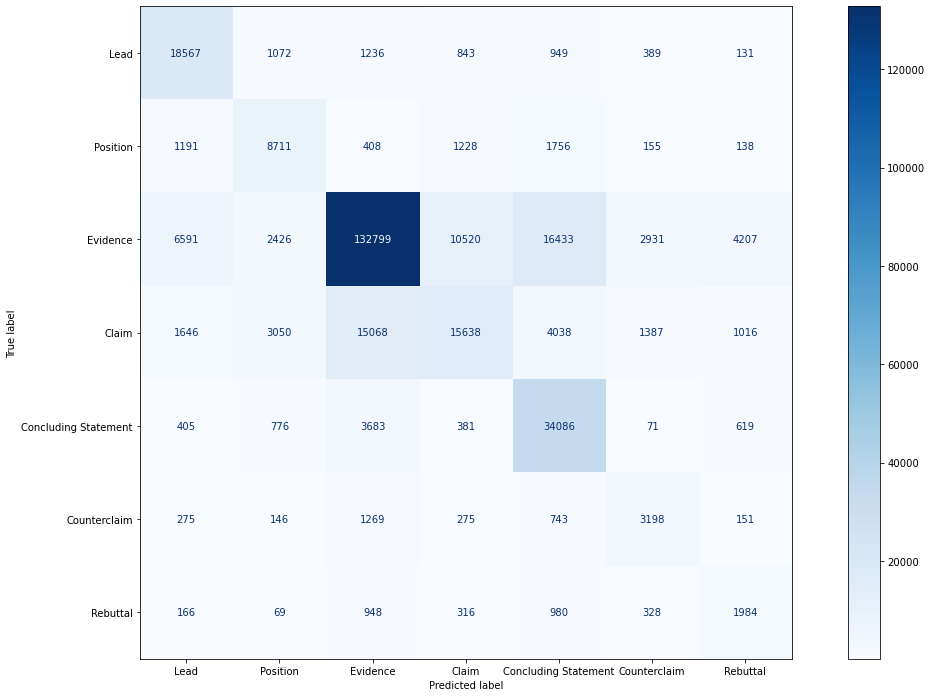

In [60]:
calc_score_for_test(merged_examples, ids, False, False, True)

weighted 0.6374491269421387
micro 0.6166585021895643
macro 0.5110556072689658
matthews_corrcoef 0.48115395752773815


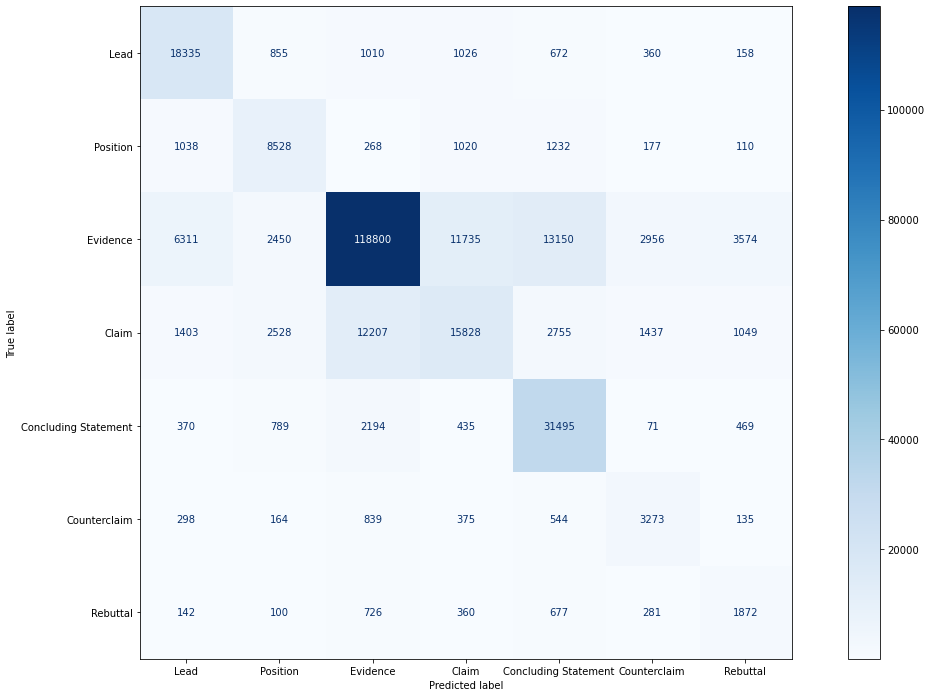

In [61]:
calc_score_for_test(merged_examples, ids, True, False, True)

weighted 0.6468606129858441
micro 0.6326875974170564
macro 0.5187816484540606
matthews_corrcoef 0.49280379225363713


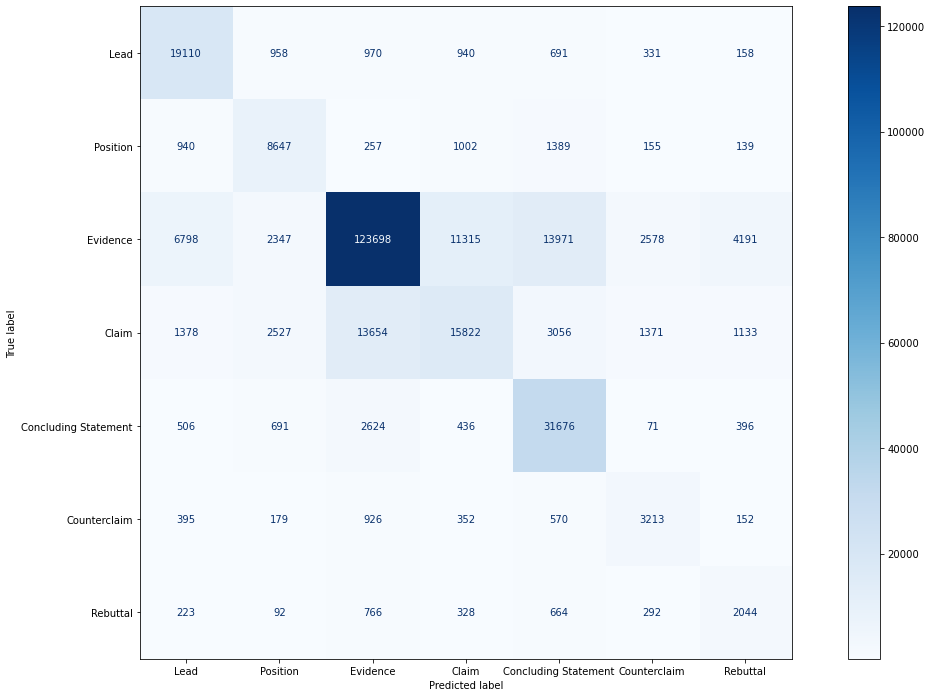

In [62]:
calc_score_for_test(merged_examples, ids, True, True, True)

weighted 0.6641304232647084
micro 0.6526801751651451
macro 0.5310247303994167
matthews_corrcoef 0.5179228859523105


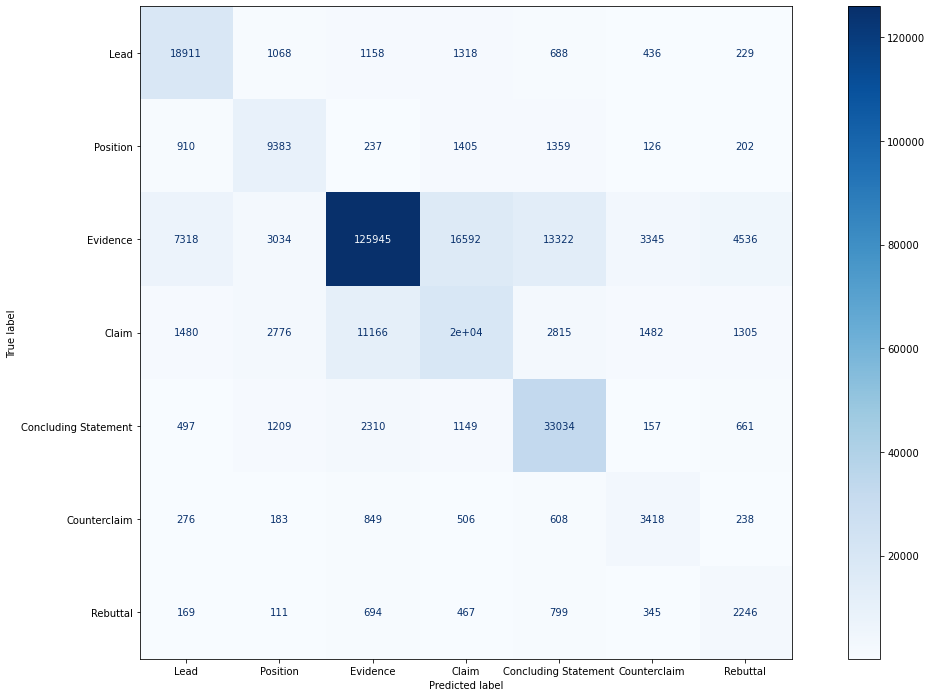

In [63]:
calc_score_for_test(inferenced_last_loose, ids)

weighted 0.6618121212153172
micro 0.650717731759816
macro 0.5300056722384677
matthews_corrcoef 0.5144186967793025


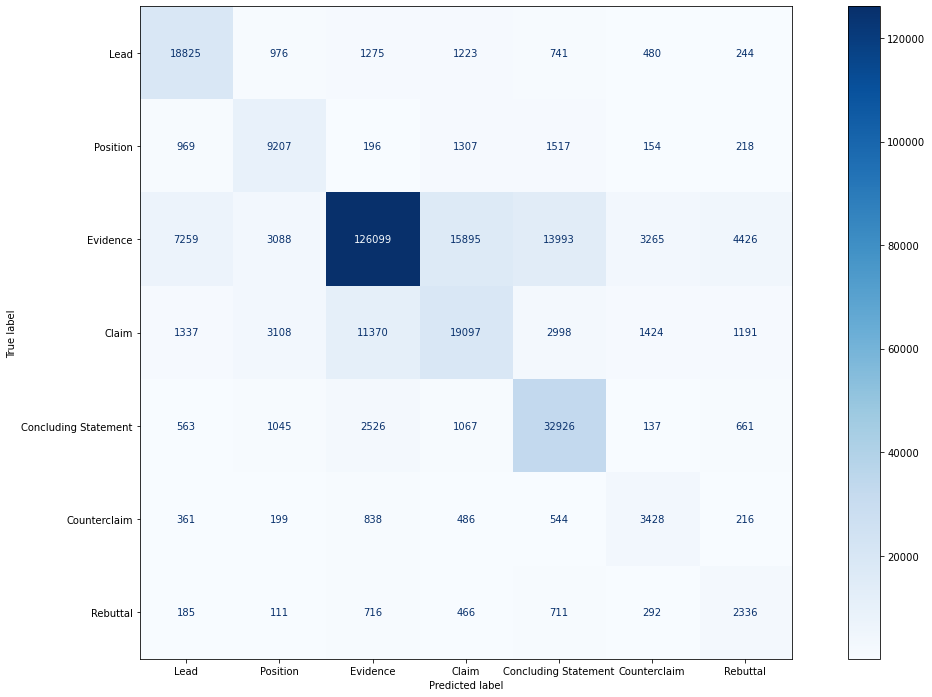

In [64]:
calc_score_for_test(inferenced_last_sents, ids)

weighted 0.6764143859497953
micro 0.669849328286202
macro 0.5403981197154882
matthews_corrcoef 0.5341033048687661


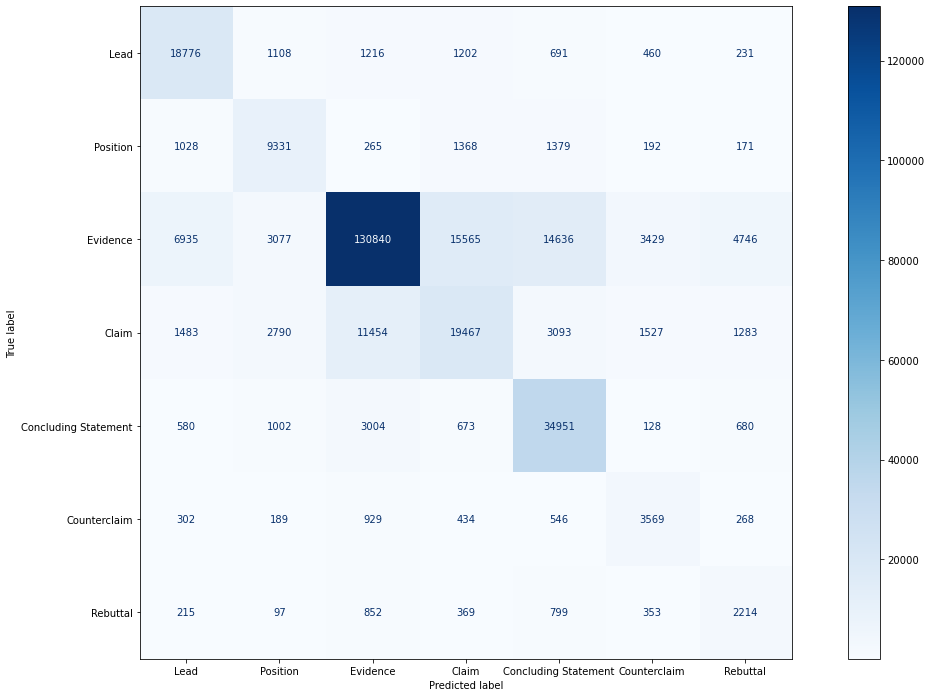

In [65]:
calc_score_for_test(inferenced_first_loose, ids)

weighted 0.6752792622697258
micro 0.6689230312476806
macro 0.5364742058041239
matthews_corrcoef 0.53145415812722


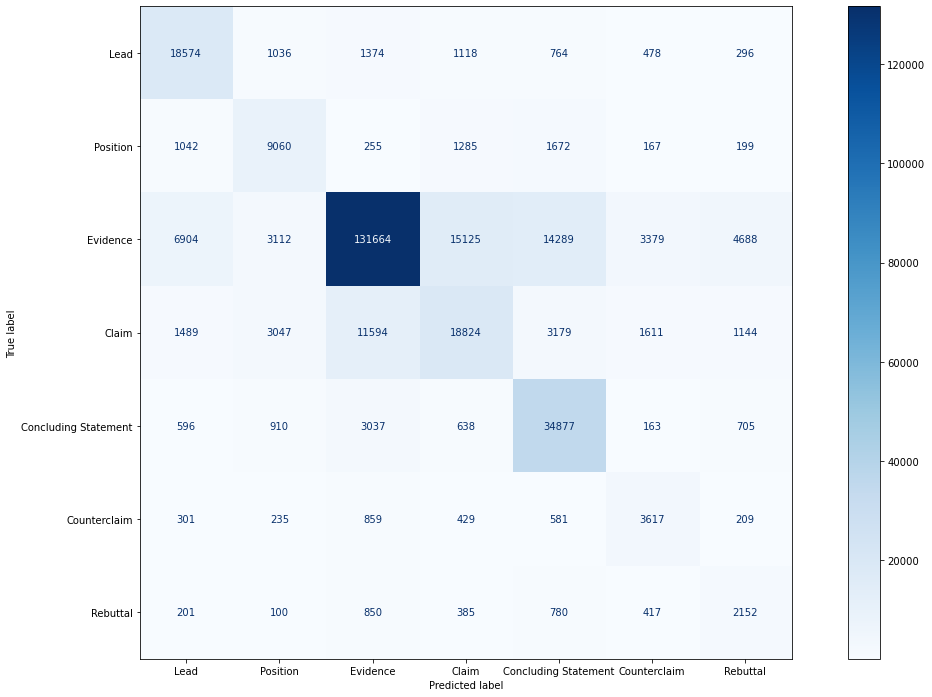

In [66]:
calc_score_for_test(inferenced_first_sents, ids)

In [88]:
xxx = loader.load_text_with_id("85B74EF4E441", purify_discourses=True, purify_text=True)
for disc in xxx.discourses:
    print(disc)

--- 1621462615722 (0 -> 85 | 0 -> 17) - Position ---
I do not like the idea of driverless cars becuase i have a lack of trust of computers
----------------------------------------------------
--- 1621462623742 (87 -> 373 | 18 -> 76) - Evidence ---
I'm old fashioned and prefur to have a human being control a machine. If i have to put my child's life into someone elses hands it would not be a computer. Now I am not saying the machine can not do it's job. I am siply saying in my opinion there are to many things that could go wrong.
-------------------------------------------------------
--- 1621462631822 (374 -> 408 | 77 -> 82) - Claim ---
Someone could hack it for instence
-----------------------------------------------------
--- 1621462644001 (410 -> 948 | 83 -> 194) - Evidence ---
They could run the vehicle of the road or ey sencers could nowfunction. Say you are going down the road and a little kid runs out infront of you. In a regular car in i can brerak every time but in a driverles

In [93]:
predict(the_model, ["So i say no. We do not need driverless cars becuase it would only end badly."])

['Concluding Statement']

In [79]:
predict(the_model, extract_discourses(inferenced_first_loose[9].predicted))

['Position',
 'Claim',
 'Position',
 'Claim',
 'Counterclaim',
 'Concluding Statement',
 'Rebuttal',
 'Evidence',
 'Counterclaim',
 'Evidence',
 'Concluding Statement']

In [77]:
extract_discourses(inferenced_first_loose[9].predicted)

['I do not like the idea of driverless cars',
 'becuase i have a lack of trust of computers',
 "I 'm old fashioned and prefur to have a human being control a machine",
 "If i have to put my child 's life into someone elses hands it would not be a computer",
 "Now I am not saying the machine can not do it 's job",
 'I am siply saying in my opinion there are to many things that could go wrong',
 'Someone could hack it for instence. They could run the vehicle of the road or ey sencers could nowfunction',
 'Say you are going down the road and a little kid runs out infront of you. In a regular car in i can brerak every time but in a driverless car if the fuse is bad or a wire is loose it may not tivate the breaking system becuase the sencer was not working. Now imagion for me if you will that kid that ran out in the road was your own child. Young and inocennt with so much life before him her. Would you really want a driverless car to be the one it ran out infront of',
 'Now I know people do

In [67]:
ppred,list_of_labels_ppred = create_discourse_doc(inferenced_last_loose[13].predicted, ids[13].strip())
rref, list_of_labels_rref = create_discourse_doc(inferenced_last_loose[13].reference, ids[13].strip(), False)

In [68]:
new_list_of_labels_ppred = [token for i,token in enumerate(list_of_labels_ppred) if i not in indexes]

NameError: name 'indexes' is not defined

In [ ]:
display_doc(ppred)
print()
display_doc(rref)